In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime as dt
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
n = 40428967  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

types_train = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

types_test = {
    'id': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

In [5]:
parse_date = lambda val : dt.datetime.strptime(val, '%y%m%d%H')

with gzip.open("train.gz") as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows = skip_values)

train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004181428767727519,0,2014-10-21,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,...,1,0,6558,320,50,571,2,39,-1,32
1,10009910814812262951,1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,a079ef6b,2347f47a,...,1,2,18993,320,50,2161,0,35,100131,157
2,10018076683759767024,1,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21300,320,50,2446,3,171,100228,156
3,10020605367282200605,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20359,216,36,2333,0,39,-1,157
4,1002186989067144726,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15708,320,50,1722,0,35,100084,79


In [6]:
train.shape

(1000000, 24)

In [7]:
train.dtypes

id                          uint64
click                        int64
hour                datetime64[ns]
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
dtype: object

Target feature -> click

site features -> site_id, site_domain, site_category

app feature -> app_id, app_domain, app_category

device feature -> device_id, device_ip, device_model, device_type, device_conn_type

anonymized categorical features -> C14-C21

In [8]:
train['click'].value_counts()

0    829969
1    170031
Name: click, dtype: int64

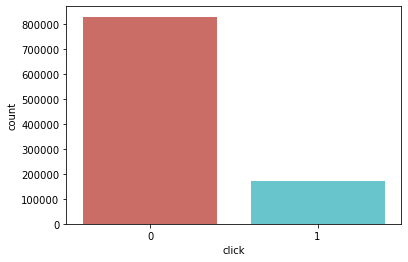

In [9]:
sns.countplot(x='click', data= train,palette='hls')
plt.show()

In [10]:
train['click'].value_counts()/len(train)

0    0.829969
1    0.170031
Name: click, dtype: float64

In [13]:
train.hour.describe()

/Users/raam/opt/anaconda3/envs/lifeofpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11144
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

### The data covers 10days of click streams from 21-10-2014 to 30-10-2014 that is 240 hours


Text(0.5, 0, 'Number of clicks by hour')

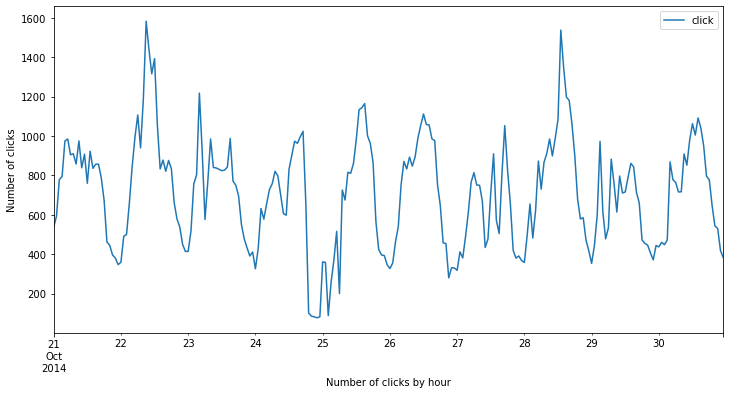

In [14]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.xlabel('Number of clicks by hour')

The hourly clicks pattern looks pretty similar every day. However, there were a couple of peak hours, one is sometime in the mid of the day on Oct 22, and another is sometime in the mid of the day on Oct 28. And one off-peak hour is close to mid-night on Oct 24.

Feature engineering for date time features

 Extract hour from date time features. 

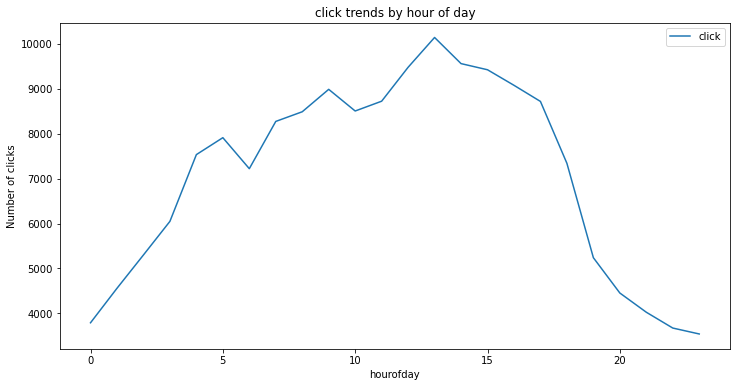

In [15]:
train['hourofday'] = train.hour.apply(lambda x: x.hour)
train.groupby('hourofday').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

In general, the highest number of clicks is at hour 13 and 14 (1pm and 2pm), and the least number of clicks is at hour 0 (mid-night). It seems a useful feature for roughly estimation.

In [16]:
train.head(4)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hourofday
0,10004181428767727519,0,2014-10-21,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,...,0,6558,320,50,571,2,39,-1,32,0
1,10009910814812262951,1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,a079ef6b,2347f47a,...,2,18993,320,50,2161,0,35,100131,157,0
2,10018076683759767024,1,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,21300,320,50,2446,3,171,100228,156,0
3,10020605367282200605,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,0,20359,216,36,2333,0,39,-1,157,0


In [17]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hourofday'],
      dtype='object')

Text(0.5, 0, 'Hourly impression vs click')

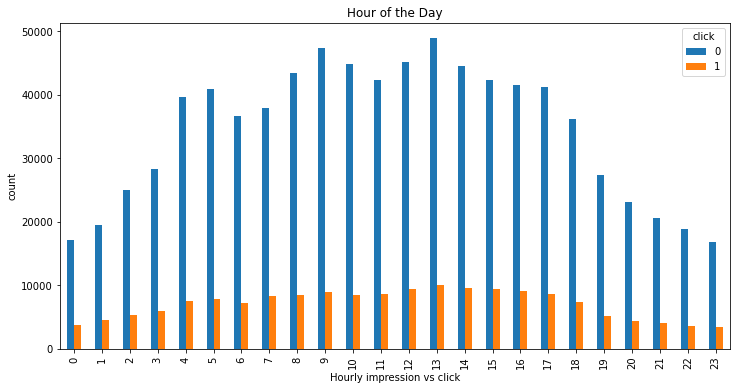

In [18]:
train.groupby(['hourofday', 'click']).size().unstack().plot(kind='bar', title='Hour of the Day',figsize=(12,6))
plt.ylabel('count')
plt.xlabel('Hourly impression vs click')

In [19]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hourofday
0,10004181428767727519,0,2014-10-21,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,...,0,6558,320,50,571,2,39,-1,32,0
1,10009910814812262951,1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,a079ef6b,2347f47a,...,2,18993,320,50,2161,0,35,100131,157,0
2,10018076683759767024,1,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,21300,320,50,2446,3,171,100228,156,0
3,10020605367282200605,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,0,20359,216,36,2333,0,39,-1,157,0
4,1002186989067144726,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,15708,320,50,1722,0,35,100084,79,0


Hourly CTR

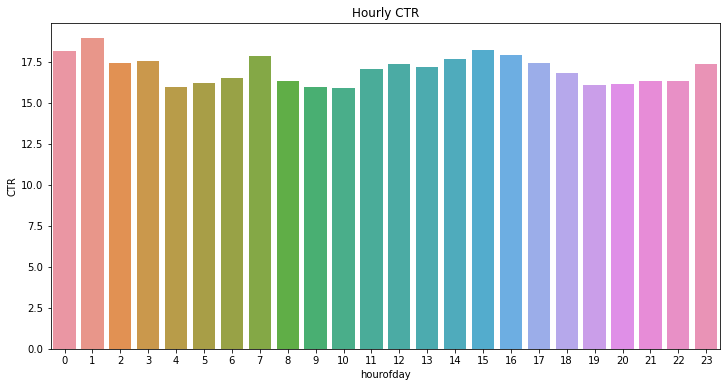

In [20]:
df_click = train[train['click'] == 1]
df_hour = train[['hourofday','click']].groupby(['hourofday']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hourofday','click']].groupby(['hourofday']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hourofday', data=df_hour)
plt.title('Hourly CTR');

One of the interesting observations here is that the highest CTR happened in the hour of mid-night, 1, 7 and 15. If you remember, around mid-night has the least number of impressions and clicks.

Day of the Week

In [24]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hourofday',
       'day_of_week'],
      dtype='object')

In [26]:
train['day_of_week'] = train['hour'].apply(lambda val: val.day_name())
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

AttributeError: 'Timestamp' object has no attribute 'weekday_name'

# C1 feature 

In [ ]:
print(train.C1.value_counts()/len(train))

### C1 is anonymized catergorical value. Although in the datafile it is not mentioned what it represents we still going ahead with data exploration

##### C1 value = 1005 has the most data, almost 92%. Let's see whether we can find value of C1 indicates something about CTR.

In [ ]:
C1_values = train.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=train.loc[np.where((train.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

In [ ]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

In [ ]:
df_c1 = train[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

In [ ]:
train['click'].mean()


## Average CTR in the data is found to be .17

In [ ]:
df_c1.CTR.describe()


### The important C1 values and CTR pairs are:

1005: 92% of the data and 0.17 CTR

1002: 5.5% of the data and 0.21 CTR

1010: 2.3% of the data and 0.096 CTR

1002 has a much higher than average CTR, and 1010 has a much lower than average CTR, it seems these two C1 values are important for predicting CTR.

## Banner Position

In [ ]:
print(train.banner_pos.value_counts()/len(train))

In [ ]:
banner_pos = train.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=train.loc[np.where((train.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for banner position: {},  click through rate: {}".format(i,ctr_avg))

In [ ]:
train.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');

In [ ]:
df_banner = train[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position');

In [ ]:
df_banner.CTR.describe()

## Device Features

In [ ]:
print("There are {} devices in the data set".format(train.device_id.nunique()))


In [ ]:
print('The top 10 devices that have the most impressions')
print((train.device_id.value_counts()/len(train))[0:10])

In [ ]:
top10_devices = (train.device_id.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_devices:
    click_avg=train.loc[np.where((train.device_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for device id value: {},  click through rate: {}".format(i,click_avg))

In [ ]:
top10_device = train[(train.device_id.isin((train.device_id.value_counts()/len(train))[0:10].index))]
top10_device_click = top10_device[top10_device['click'] == 1]
top10_device.groupby(['device_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 device ids histogram');

In [ ]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
train = convert_obj_to_int(train)

In [ ]:
train.head()